In [1]:
import os
from pymatgen.core import Structure
from pymatgen.io.vasp.inputs import Poscar, Incar, Kpoints
from pymatgen.io.vasp.sets import MPRelaxSet, MPStaticSet
from pymatgen.io.vasp.outputs import Vasprun
from src.file_builder import create_job_script
from src.solver import energy_list_getter, find_good_structures
import matplotlib.pyplot as plt
from time import sleep, gmtime, strftime
from tqdm import tqdm
import numpy as np
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def submit_all_jobs(input_path: str, submit_path: str) -> None:
    submit_full_path = os.path.join(input_path, submit_path)
    initial_path = os.getcwd()
    for folder_name in os.listdir(submit_full_path):
        os.chdir(initial_path)
        tmp_path = os.path.join(submit_full_path, folder_name)
        os.chdir(tmp_path)
        os.system('sbatch jobscript.sh')
    os.chdir(initial_path)

def get_ecut_files(input_path: str, ecut_range: list)-> None:
    ecut_opt_path = os.path.join(input_path, 'encut')
    if not os.path.exists(ecut_opt_path):
        os.mkdir(ecut_opt_path)
    structure = Structure.from_file(os.path.join(input_path, 'POSCAR'))
    for ecut in ecut_range:
        user_settings = {'ENCUT' : ecut,'EDIFF' : 1E-7, 'NCORE': 4,
                         'LDAU' : False,
                         'LVHAR' : False,
                         'LCHARG': False,
                         'LAECHG' : False,
                         'LASPH' : False}
        ecut_path = os.path.join(input_path, 'encut', str(ecut))
        if not os.path.exists(ecut_path):
            os.mkdir(ecut_path)
        static_set = MPStaticSet(structure, user_incar_settings=user_settings)
        static_set.get_vasp_input().write_input(ecut_path)
        create_job_script(out_path=ecut_path, ntasks=24)

        
def en_per_atom_list(input_path : str, mode : str)-> tuple:
    E_list = []
    kpoints_path = os.path.join(input_path, mode)
    kpoints_range = sorted([int(d) for d in os.listdir(kpoints_path) if '.' not in d])
    for kpoint_density in tqdm(kpoints_range):
        struct_folder = os.path.join(kpoints_path, str(kpoint_density))
        vasprun_path = os.path.join(struct_folder, 'vasprun.xml')
        vasprun = Vasprun(vasprun_path, parse_dos=False, parse_eigen=False)
        E_tot = vasprun.final_energy
        E_list.append(E_tot)

    initial_atoms_num = len(Structure.from_file(os.path.join(input_path, 'POSCAR')))
    energy_arr = np.array(E_list) / initial_atoms_num
    return energy_arr, kpoints_range        
        
def get_ecut(en_per_atom: list, ecut_range)-> int:
    y = np.diff(en_per_atom * 1000) #diff in meV
    x = ecut_range[1:]
    Ecut = x[np.argmin(abs(y))]
    return Ecut

def plot_encut(input_path: str, en_per_atom: list, ecut_range: list)-> None:
    x = ecut_range
    y = (en_per_atom - min(en_per_atom)) * 1000 # to meV
    Ecut = get_ecut(en_per_atom, ecut_range)
    i = list(ecut_range).index(Ecut)
    plt.figure(figsize=(12, 6), dpi=200)
    plt.plot(x, y, 'o-', c='r')
    plt.scatter(x[i], y[i], s=200, c='r')
    plt.ylabel('E/atom, meV')
    plt.xlabel('Encut, eV')
    plt.xticks(x, rotation=45, ha='right')
    plt.savefig(os.path.join(input_path, 'Encut.pdf'), bbox_inches='tight')

def write_kpoints(file_name, Rk):
    with open(file_name, 'w') as f:
        st = f"""Automatic mesh
0              ! number of k-points = 0 -> automatic generation scheme 
Auto           ! fully automatic
{Rk}           ! length (R_k)"""
        f.write(st)

def get_kpoints_files(input_path: str, Ecut: int, kpoints_range: list)-> None:
    kpoints_opt_path = os.path.join(input_path, 'kpoints')
    if not os.path.exists(kpoints_opt_path):
            os.mkdir(kpoints_opt_path)

    structure = Structure.from_file(os.path.join(input_path, 'POSCAR'))
    for kpoints in tqdm(kpoints_range):
        user_settings = {'ENCUT' : Ecut,
                         'EDIFF' : 1E-7, 'NCORE': 4,
                         'LDAU' : False,
                         'LVHAR' : False,
                         'LCHARG': False,
                         'LAECHG' : False,
                         'LASPH' : False}
        kpoints_path = os.path.join(input_path, 'kpoints', str(kpoints))
        file_name = os.path.join(kpoints_path, 'KPOINTS')
        if not os.path.exists(kpoints_path):
            os.mkdir(kpoints_path)    
        static_set = MPStaticSet(structure, user_incar_settings=user_settings)
        static_set.get_vasp_input().write_input(kpoints_path)
        write_kpoints(file_name, Rk=kpoints)
        create_job_script(out_path=kpoints_path, ntasks=20)    
    
def check_readiness(input_path: str, submit_path:str)-> None:
    submit_full_path = os.path.join(input_path, submit_path)
    initial_path = os.getcwd()
    pathes = sorted(os.listdir(submit_full_path))
    converged_list = []
    while len(converged_list) != len(pathes):
        print(strftime("%H:%M:%S", gmtime()))
        converged_list = []
        for folder_name in pathes:
            file_path = os.path.join(submit_full_path, folder_name, 'log')
            if os.path.exists(file_path):
                with open(file_path) as f:
                    if 'E0' in f.readlines()[-1]:
                        converged_list += [folder_name]
                    else:
                        print(f'{folder_name} not yet converged') 
            else:
                print(f'{folder_name} not yet written')
        print('\n')
        sleep(10)
    print(strftime("%H:%M:%S", gmtime()))
    print('All structures converged! Starting Encut estimation.')


def plot_kpoints(input_path: str, en_per_atom: list, kpoints_range: list)-> None:
    y = (energy_arr - min(energy_arr)) * 1000
    x = kpoints_range
    plt.figure(figsize=(12, 6), dpi=200)
    plt.plot(x, y, 'o-', label='Sigma = 0.05', c='b')
    plt.ylabel('E/atom, meV')
    plt.xlabel(r'$R_K$')
    plt.xticks(x, rotation=45, ha='right')
    plt.legend()
    plt.savefig(os.path.join(input_path, 'Kgrid.pdf'), bbox_inches='tight')
    
def get_kpoint_density(energy_arr: list, kpoints_range)-> int:
    y = np.diff(energy_arr * 1000) #diff in meV
    x = kpoints_range[1:]
    R_k = x[np.where(abs(y) < 0.5)[0][0]]
    return R_k

In [11]:
# get_ecut_files(input_path, ecut_range)
# submit_all_jobs(input_path=input_path, submit_path='encut')
# check_readiness(input_path, submit_path='encut')

In [22]:
def check_readiness(input_path: str, submit_path: str) -> None:
    submit_full_path = os.path.join(input_path, submit_path)
    pathes = sorted(os.listdir(submit_full_path))
    converged_list = []
    while len(converged_list) != len(pathes):
        tmp_time = strftime("%H:%M:%S", gmtime())
        print(f'{tmp_time} {submit_path.upper()} optimization')
        converged_list = []
        for folder_name in pathes:
            file_path = os.path.join(submit_full_path, folder_name, 'OSZICAR')
            if os.path.exists(file_path):
                with open(file_path) as f:
                    text = f.readlines()
                    if text and ('E0' in text[-1]):
                        converged_list += [folder_name]
                    else:
                        print(f'{folder_name} not yet converged')
            else:
                print(f'{folder_name} not yet written')
        print('\n')
        sleep(15)
    time = strftime("%H:%M:%S", gmtime())
    print(f'{time} {submit_path.upper()} optimization Finished')

In [24]:
input_path =  'examples/Fe_stat/'

100%|███████████████████████████████████████████| 12/12 [00:11<00:00,  1.07it/s]


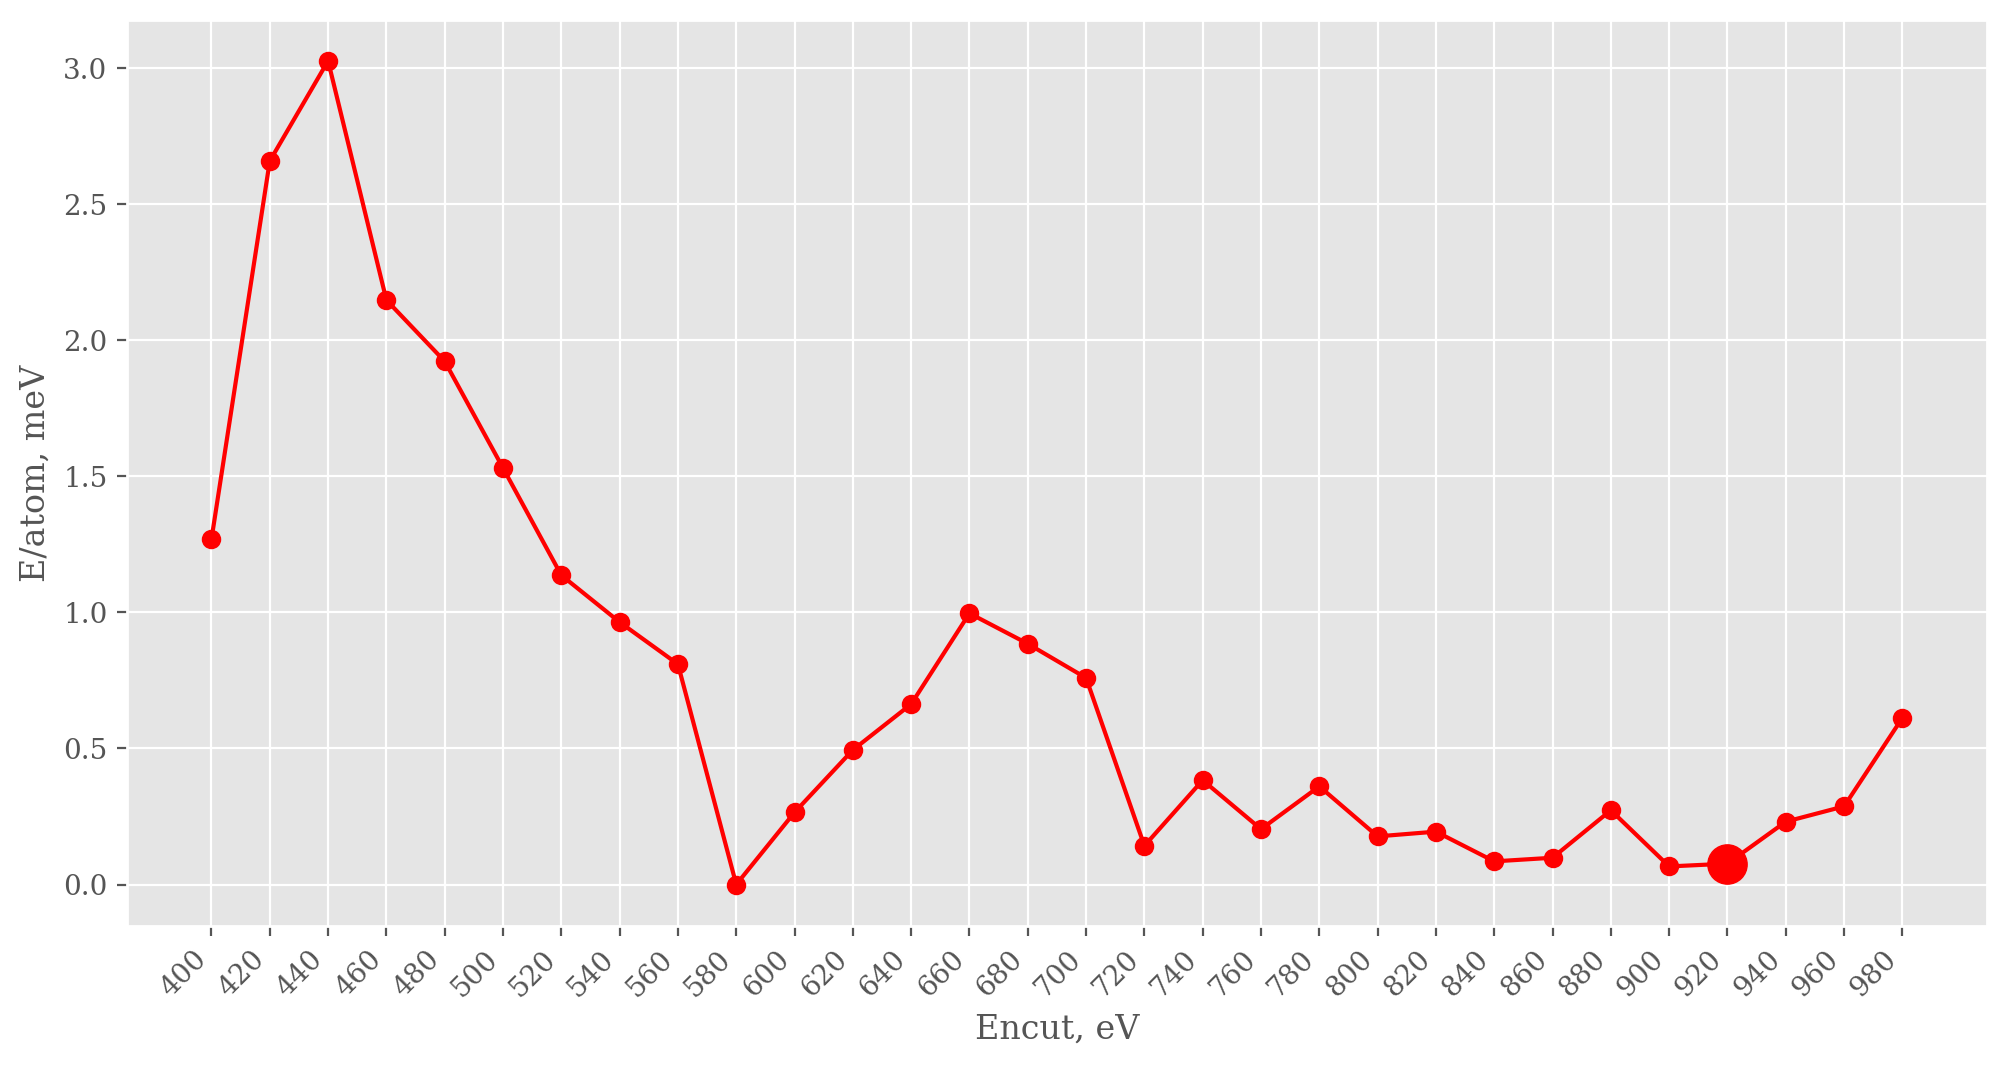

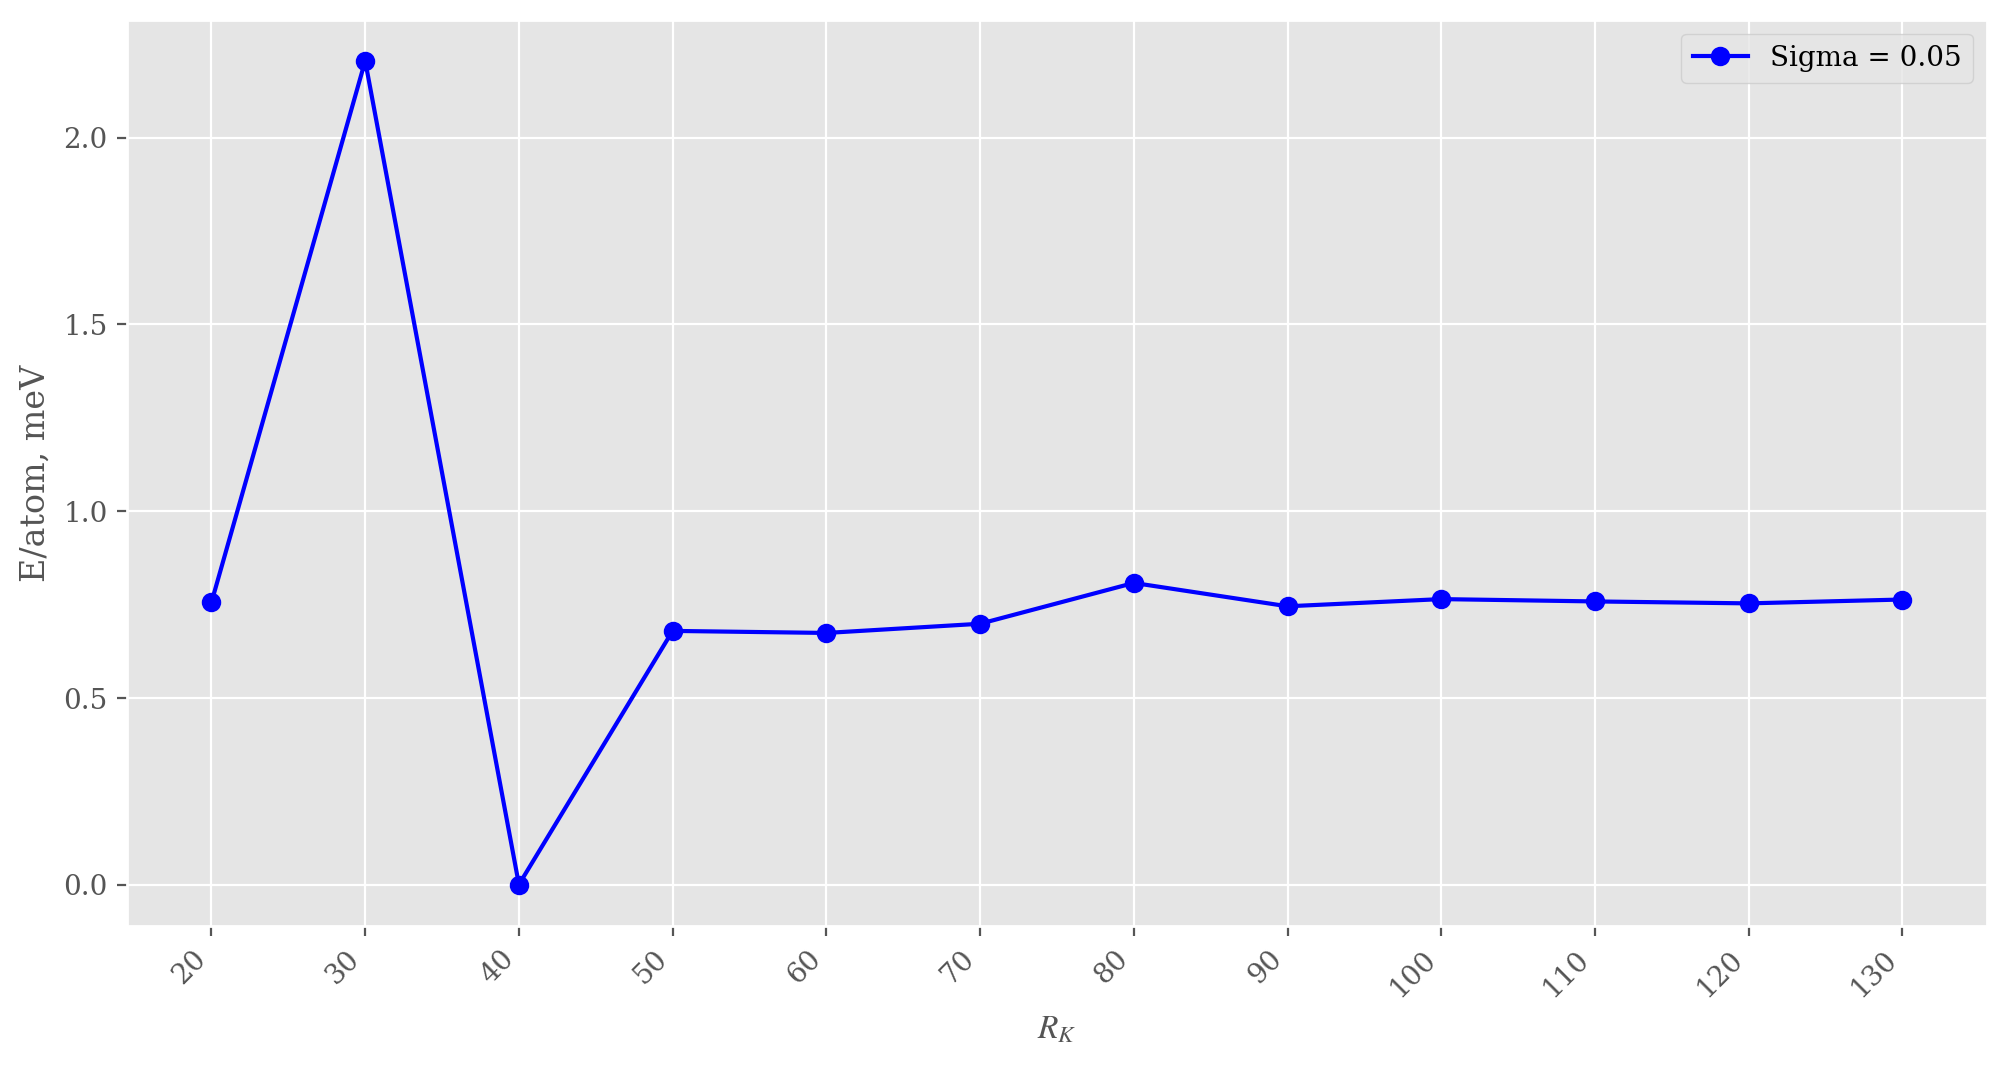

In [5]:
ecut_range = np.arange(400, 1000, 20)

encut_arr, encut_range = en_per_atom_list(input_path, mode = 'encut')
Ecut = get_ecut(encut_arr, encut_range)

energy_arr, kpoints_range = en_per_atom_list(input_path, mode = 'kpoints')
plot_encut(input_path, encut_arr, encut_range)
plot_kpoints(input_path, energy_arr, kpoints_range)
R_k = get_kpoint_density(energy_arr, kpoints_range)

In [25]:
def plot_kpoints(input_path: str, en_per_atom: list, kpoints_range: list)-> None:
    y = (energy_arr - min(energy_arr)) * 1000
    x = kpoints_range
    plt.figure(figsize=(12, 6), dpi=200)
    plt.plot(x, y, 'o-', label='Sigma = 0.05')
    plt.plot(x, y, 'o-', label='Sigma = 0.10')
    plt.plot(x, y, 'o-', label='Sigma = 0.10')
    plt.plot(x, y, 'o-', label='Sigma = 0.20')
    plt.ylabel('E/atom, meV')
    plt.xlabel(r'$R_K$')
    plt.xticks(x, rotation=45, ha='right')
    plt.legend()
    plt.savefig(os.path.join(input_path, 'Kgrid.pdf'), bbox_inches='tight')

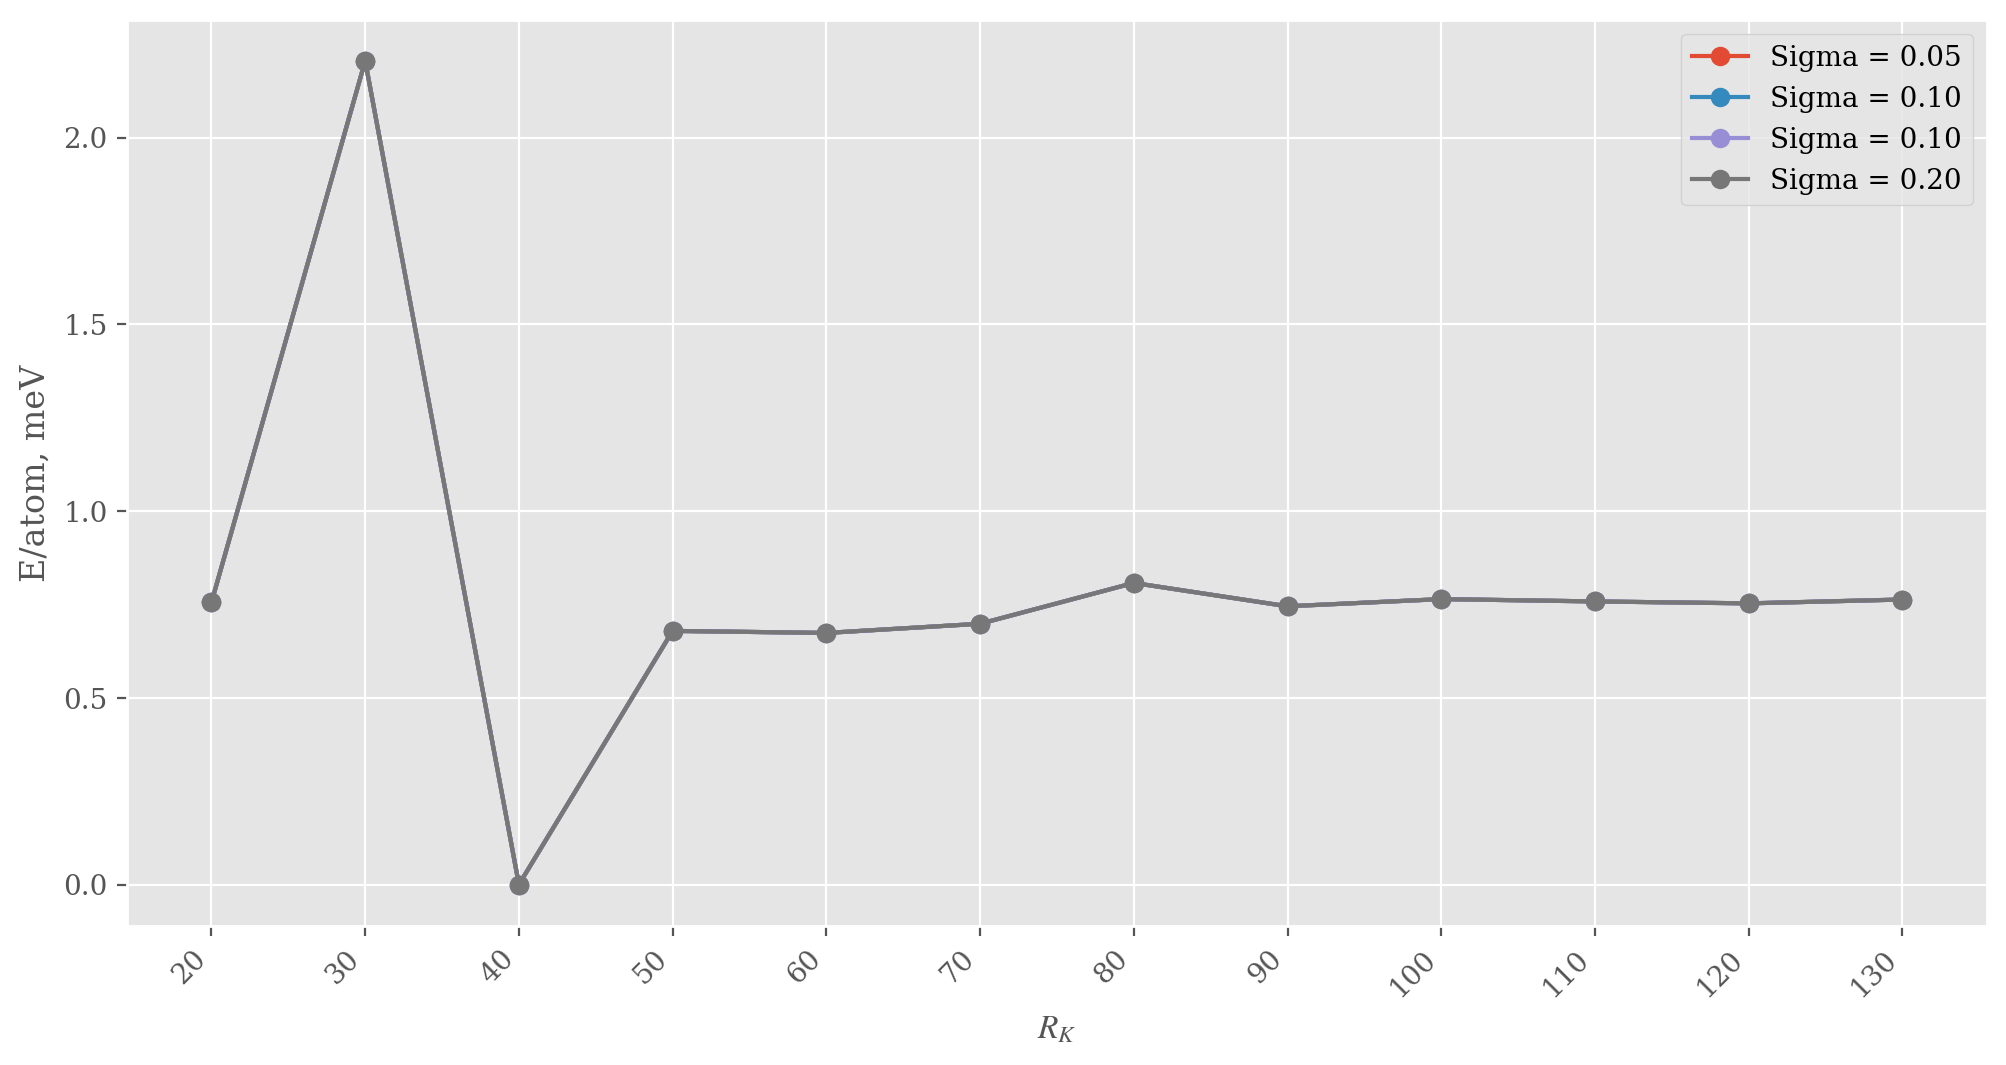

In [27]:
plot_kpoints(input_path, energy_arr, kpoints_range)

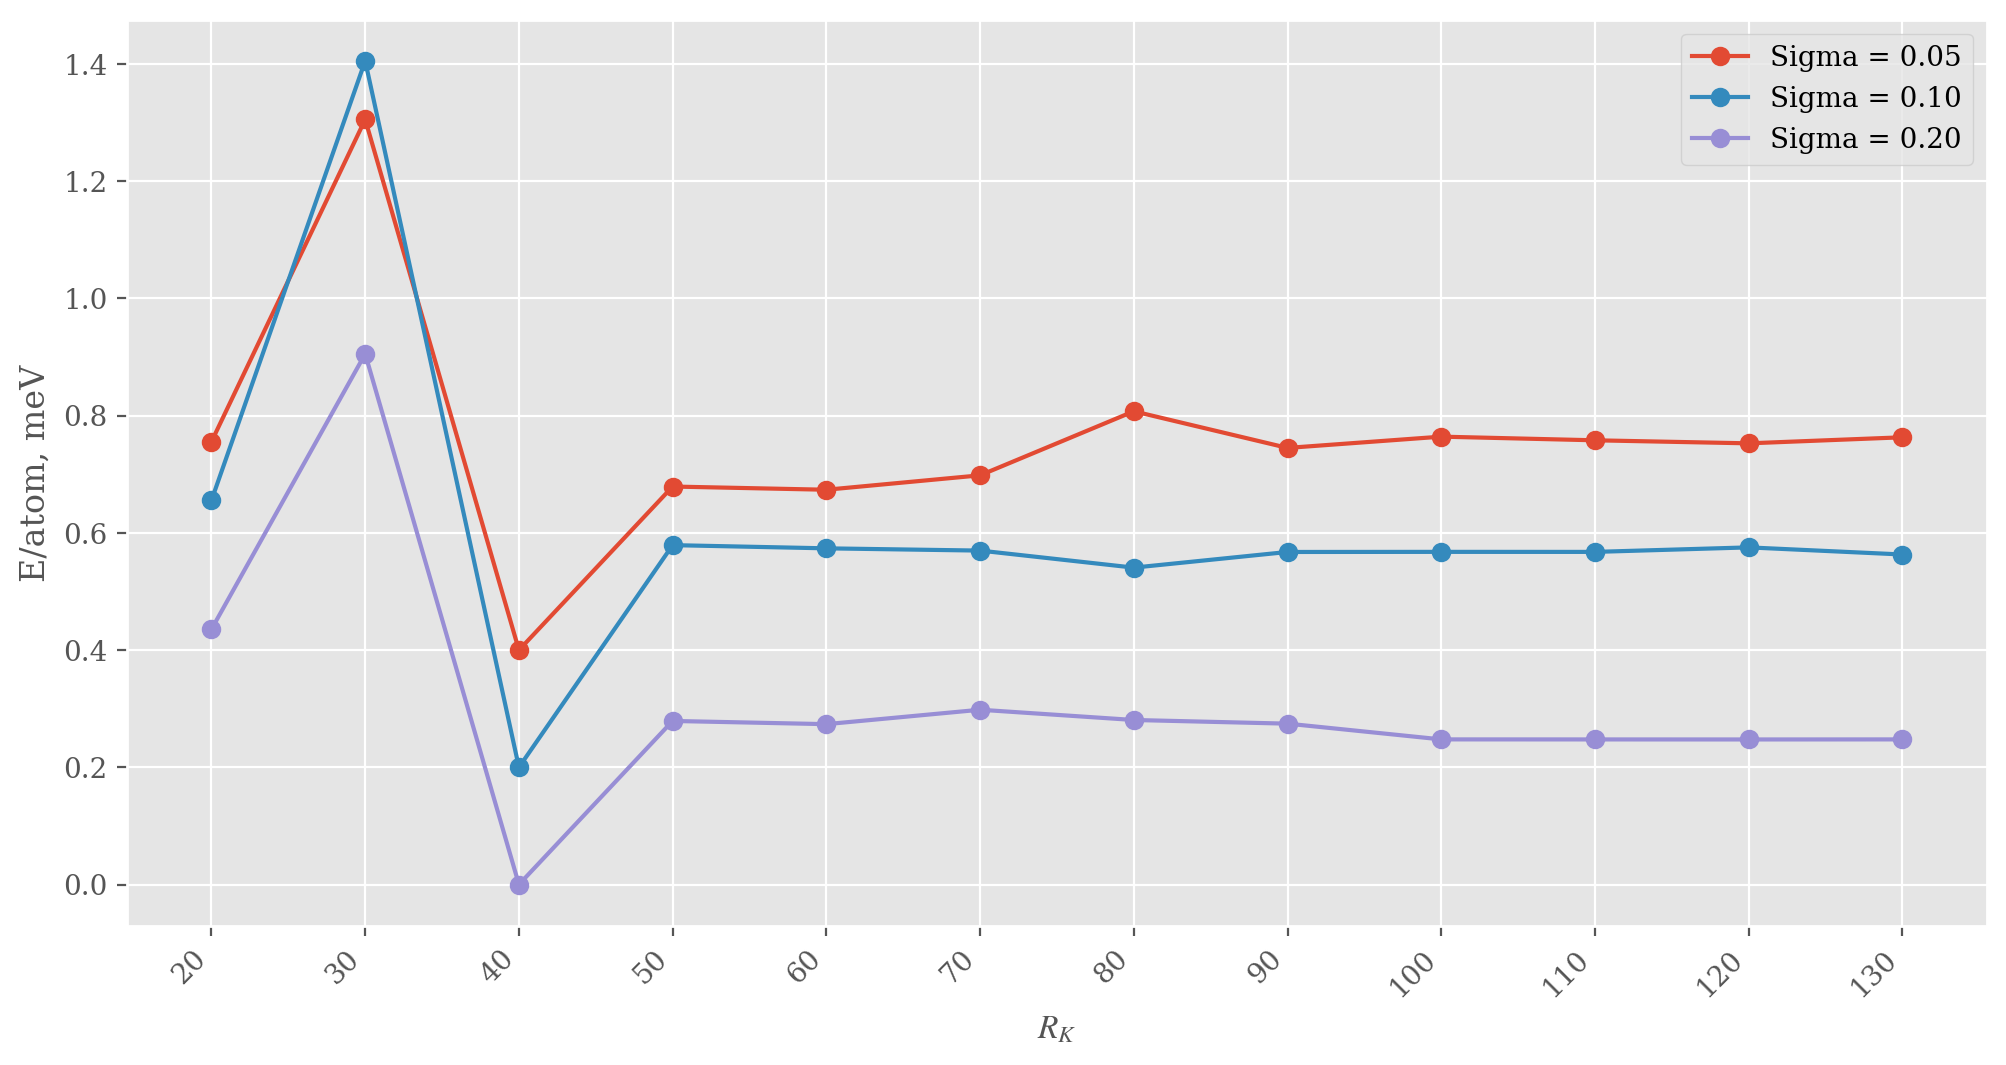

In [54]:
y =    [0.75561,  1.30545,  0.4, 0.67911, 0.67365, 0.69824, 0.807515, 0.74502 , 0.76425 , 0.75801 , 0.752825, 0.76314 ]
y_01 = [0.65561 , 1.40545 , 0.2, 0.57911, 0.57365, 0.56982, 0.5407515, 0.5674502 , 0.5676425 , 0.5675801 , 0.5752825, 0.56314 ]
y_02 = [0.43561 , 0.90545 , 0.0, 0.27911, 0.27365, 0.29824, 0.2807515, 0.274502 , 0.2476425 , 0.2475801 , 0.24752825, 0.2476314 ]
x = kpoints_range
plt.figure(figsize=(12, 6), dpi=200)
plt.plot(x, y, 'o-', label='Sigma = 0.05')
plt.plot(x, y_01, 'o-', label='Sigma = 0.10')
plt.plot(x, y_02, 'o-', label='Sigma = 0.20')
plt.ylabel('E/atom, meV')
plt.xlabel(r'$R_K$')
plt.xticks(x, rotation=45, ha='right')
plt.legend()
plt.savefig(os.path.join(input_path, 'Kgrid.pdf'), bbox_inches='tight')

In [31]:
y

array([0.75561 , 2.20545 , 0.      , 0.67911 , 0.67365 , 0.69824 ,
       0.807515, 0.74502 , 0.76425 , 0.75801 , 0.752825, 0.76314 ])